In [1]:
%load_ext autoreload
%autoreload 2

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sensioai/dl/blob/master/training/training.ipynb)

# Training Neural Networks

In this notebook we are going to see a step by step guide on how to effectively train a neural network.

## Data Exploration


To train a Neural Network in a supervised way we need data, and it is a good idea to explore that data before anything else. This step will give us an idea of the type of data we are working with. In this case, we are going to use the [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset, an image dataset to perform image classification. Before training we need to know aspects of the dataset such as:

- Number of classes
- Number of channels (gray, color, multi-espectral, ...)
- Resolution (height and width)
- Dataset statistics (mean/std or max/min values)
- Data type (unit8, float16, ...)
- Class distribution
- Any other aspect relevant to the particular case

In [2]:
import torchvision

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

len(trainset), len(testset)

Files already downloaded and verified
Files already downloaded and verified


(50000, 10000)

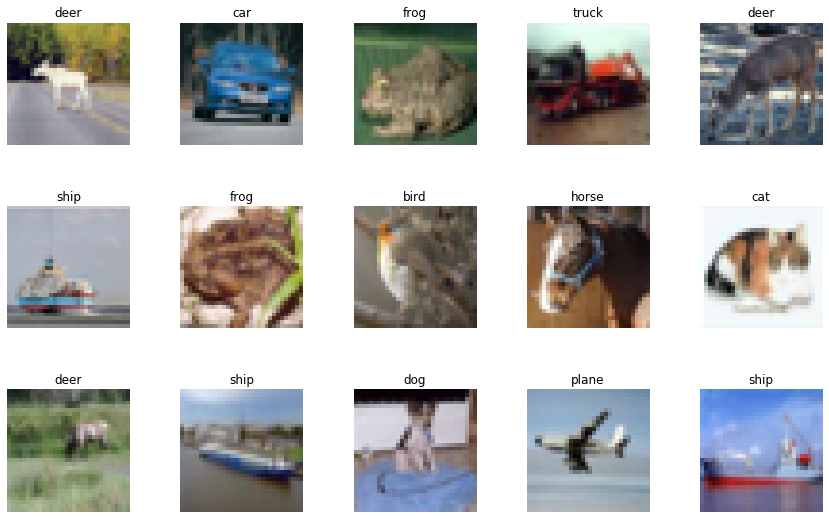

In [3]:
# visualize some images

import random 
import matplotlib.pyplot as plt

r, c = 3, 5
plt.figure(figsize=(c*3, r*3))
for row in range(r):
    for col in range(c):
        index = c*row + col
        plt.subplot(r, c, index + 1)
        ix = random.randint(0, len(trainset)-1)
        img, label = trainset[ix]
        plt.imshow(img)
        plt.axis('off')
        plt.title(classes[label])
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

In [4]:
img.size

(32, 32)

The dataset gives us `PIL` images, we can convert them to `numpy` arrays like this

In [5]:
import numpy as np

train_images = np.array([np.array(img) for img, label in trainset])
test_images = np.array([np.array(img) for img, label in testset])

train_labels = np.array([label for img, label in trainset])
test_labels = np.array([label for img, label in testset])

train_images.shape, test_images.shape, train_labels.shape, test_labels.shape

((50000, 32, 32, 3), (10000, 32, 32, 3), (50000,), (10000,))

Usually, images will be of type `unit8`, unsigned 8-bytes integer values that range between 0 and 255. Nevertheless, non-natural images (like satellite or medical) can have different types.

In [6]:
train_images.dtype, train_labels.dtype

(dtype('uint8'), dtype('int32'))

In [7]:
# max and min values for each channel

max_value = train_images.max(axis=(0, 1, 2))
min_value = train_images.min(axis=(0, 1, 2))

max_value, min_value

(array([255, 255, 255], dtype=uint8), array([0, 0, 0], dtype=uint8))

Mean and standard deviation are usually computed on the normalized images (dividing by 255)

In [8]:
# compute statistics

# mean and std for each channel

mean = (train_images / 255).mean(axis=(0, 1, 2))
std = (train_images / 255).std(axis=(0, 1, 2))

mean, std

(array([0.49139968, 0.48215841, 0.44653091]),
 array([0.24703223, 0.24348513, 0.26158784]))

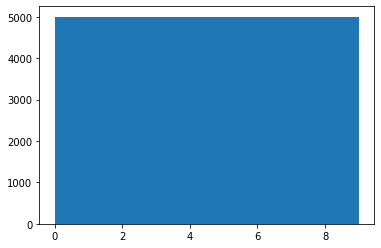

In [9]:
# class distribution

plt.hist(train_labels, bins=len(classes))
plt.show()

In [10]:
unique, counts = np.unique(train_labels, return_counts=True)
unique, counts

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000],
       dtype=int64))

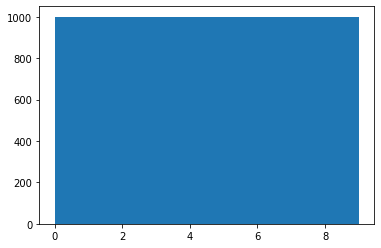

In [11]:
plt.hist(test_labels, bins=len(classes))
plt.show()

In this case our dataset is **balanced** (same number of samples for each class). If this was not the case we may want to do something about it:

- gathering more data for less represented classes 
- eliminating samples from the most predominant classes
- artificially increase the dataset (data augmentation)

If not, we can induce bias to our model.

## Training the network

Now that we are familiar with our data, we could attempt to train a model with all our dataset and see how it goes... However, this if there is some mistake in the pipeline, it could be hard to debug. It can also happen that the network trains without complaining, but achieving bad results.

In order to reduce the probabilities of problems, it is recommended to follow this steps:

- Fit one sample to make sure everything works
- Fit one batch to make sure everything works
- Train on a small representative data subset to explore different options
- Finally, train on all the data

### Fit one sample

Fitting only one image can be very useful to make sure that our model is well built and everything works as expected. If we miss something, we will be able to debug our model easily at this step. Common problems that this step can catch early are:

- Bad definition of the Dataset or DataLoader
- Miss-shaped tensor dimensions (on the data or the network)
- Wrong optimizer or loss function

If everything works fine, any model (with a minimum ammount of parameters) should be able to memorize one sample.

In [12]:
import torch

class Dataset(torch.utils.data.Dataset):
  def __init__(self, X, stats, y=None, train=True):
    self.X = X
    self.mean, self.std = stats
    self.y = y
    self.train = train

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    img = self.X[ix]
    img = torch.from_numpy(img / 255.)
    img = (img - self.mean) / self.std
    img = img.view(-1).float()
    if self.train:
        label = torch.tensor(self.y[ix]).long()
        return img, label
    return img

In [13]:
train_dataset = Dataset(train_images[:1], (mean, std), train_labels[:1])

len(train_dataset)

1

In [14]:
img, label = train_dataset[0]

img.shape, label.shape

(torch.Size([3072]), torch.Size([]))

If we undo the operations done by the `Dataset` the images should be equal to our original ones (before normalization and reshaping).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


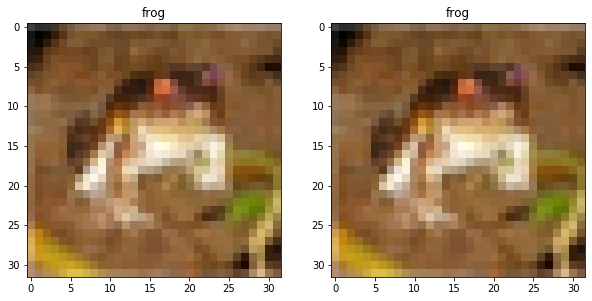

In [15]:
def compare(ix):
    plt.figure(figsize=(10, 20))
    plt.subplot(121)
    plt.imshow(train_images[ix])
    plt.title(classes[train_labels[ix]])
    plt.subplot(122)
    img, label = train_dataset[ix]
    img = img.reshape(32, 32, 3)
    img = img*std + mean
    plt.imshow(img)
    plt.title(classes[label])
    plt.show()
    
compare(0)

In [16]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=3)

batch = next(iter(train_dataloader))
imgs, labels = batch

imgs.shape, labels.shape

(torch.Size([1, 3072]), torch.Size([1]))

In [17]:
net = torch.nn.Sequential(
    torch.nn.Linear(32*32*3, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 10)
)

net

Sequential(
  (0): Linear(in_features=3072, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=10, bias=True)
)

In [18]:
from src import Model, Accuracy

net = torch.nn.Sequential(
    torch.nn.Linear(32*32*3, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 10)
)

model = Model(net)

model.compile(optimizer = torch.optim.SGD(model.net.parameters(), lr=0.01),
              loss = torch.nn.CrossEntropyLoss(),
              metrics=[Accuracy()])

hist = model.fit(train_dataloader, epochs=3)

In [19]:
test_dataloader = DataLoader(Dataset(train_images[:1], stats=(mean, std), train=False), batch_size=1)

preds = model.predict(test_dataloader)
preds

tensor([[-0.6905, -0.8432, -0.4906, -0.8569, -0.6326, -0.0478,  3.9447,  0.7680,
         -0.9110,  0.0271]], device='cuda:0')

In [20]:
classes[torch.argmax(preds, axis=1).item()]

'frog'

If our network is able to memorize one image, then we can already discard a lot of possible problems that can arise during training.

### Fit one batch

If everything is well defined, we should be able to do the same for just one batch of images.

In [21]:
batch_size = 16
train_dataset = Dataset(train_images[:batch_size], (mean, std), train_labels[:batch_size])
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
batch = next(iter(train_dataloader))
imgs, labels = batch

len(train_dataset), imgs.shape, labels.shape

(16, torch.Size([16, 3072]), torch.Size([16]))

In [22]:
net = torch.nn.Sequential(
    torch.nn.Linear(32*32*3, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 10)
)

model = Model(net)

model.compile(optimizer = torch.optim.SGD(model.net.parameters(), lr=0.01),
              loss = torch.nn.CrossEntropyLoss(),
              metrics=[Accuracy()])

hist = model.fit(train_dataloader, epochs=5)

In [23]:
test_dataloader = DataLoader(Dataset(train_images[:batch_size], stats=(mean, std), train=False), batch_size=batch_size)

preds = model.predict(test_dataloader)
preds = torch.argmax(preds, axis=1)
preds

tensor([6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9], device='cuda:0')

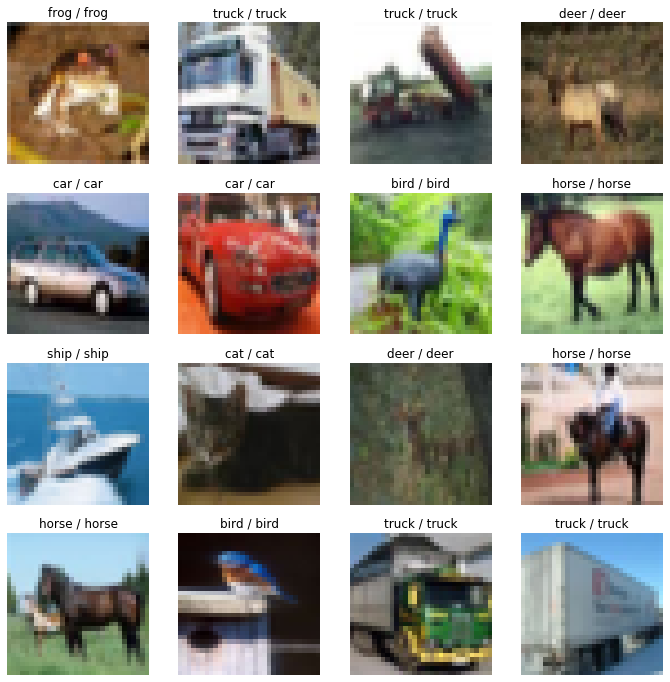

In [24]:
r, c = 4, 4
plt.figure(figsize=(c*3, r*3))
for row in range(r):
    for col in range(c):
        ix = c*row + col
        plt.subplot(r, c, ix + 1)
        plt.imshow(train_images[ix])
        plt.axis('off')
        plt.title(f"{classes[train_labels[ix]]} / {classes[preds[ix].item()]}")
plt.subplots_adjust(wspace=0.1, hspace=0.2)
plt.show()

### Train on subset

We want our subset to be representative of the entire data, so we need the same class distribution.

In [25]:
from sklearn.model_selection import train_test_split

_, subset_images, _, subset_labels = train_test_split(train_images, train_labels, test_size=0.1, shuffle=True, stratify=train_labels, random_state=42)

subset_images.shape, subset_labels.shape

((5000, 32, 32, 3), (5000,))

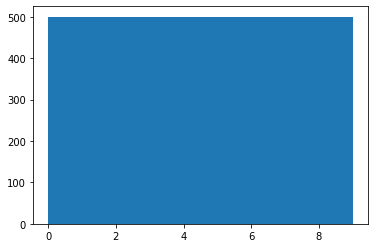

In [26]:
plt.hist(subset_labels, bins=len(classes))
plt.show()

We can use our subsampled dataset to find a good balance between the batch size and the learning rate for the fastest convergence

In [27]:
batch_size = 64
train_dataset = Dataset(subset_images, (mean, std), subset_labels)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)

len(train_dataset)

5000

In [28]:
net = torch.nn.Sequential(
    torch.nn.Linear(32*32*3, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 10)
)

model = Model(net)

model.compile(optimizer = torch.optim.SGD(model.net.parameters(), lr=0.1),
              loss = torch.nn.CrossEntropyLoss(),
              metrics=[Accuracy()])

hist = model.fit(train_dataloader, epochs=40)

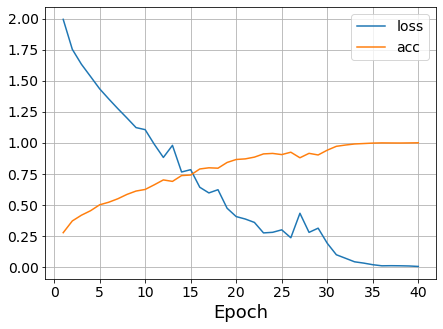

In [29]:
import pandas as pd
import matplotlib 

matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 
matplotlib.rc('legend', fontsize=14)

def plot_hist(history):
  fig = plt.figure(figsize=(7, 5))
  plt.plot(history["epochs"], history["metrics"]["loss"], label="loss")
  plt.plot(history["epochs"], history["metrics"]["acc"], label="acc")
  plt.grid(True)
  plt.xlabel("Epoch", fontsize=18)
  plt.legend()
  plt.show()

plot_hist(hist)

WOW ! 100% accuracy. Did we just train the best classifier ever ?

In [30]:
test_dataset = Dataset(test_images, (mean, std), test_labels)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)

model.evaluate(test_dataloader)

Our model predicts perfectly the *train* set but it is very bad on the *test* set. We need to *evaluate* our model during training in order to know its performance on *unseen* data.

## Train-validation-test data split

We want our **validation** set to be representative of the entire dataset, and the number of samples will depend on the problem (usually 10-30% of training data is enough).

In [31]:
from sklearn.model_selection import train_test_split

train_images, eval_images, train_labels, eval_labels = train_test_split(train_images, train_labels, test_size=0.2, shuffle=True, stratify=train_labels, random_state=42)
_, subset_images, _, subset_labels = train_test_split(train_images, train_labels, test_size=0.2, shuffle=True, stratify=train_labels, random_state=42)

train_images.shape, eval_images.shape, train_labels.shape, eval_labels.shape, subset_images.shape, subset_labels.shape

((40000, 32, 32, 3),
 (10000, 32, 32, 3),
 (40000,),
 (10000,),
 (8000, 32, 32, 3),
 (8000,))

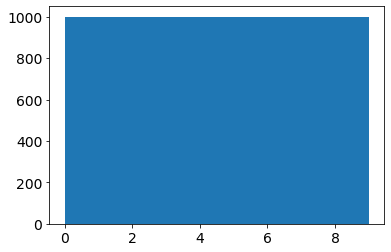

In [32]:
plt.hist(eval_labels, bins=len(classes))
plt.show()

In [33]:
train_dataset = Dataset(subset_images, (mean, std), subset_labels)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)

eval_dataset = Dataset(eval_images, (mean, std), eval_labels)
eval_dataloader = DataLoader(eval_dataset, shuffle=False, batch_size=1000)

len(train_dataset), len(eval_dataset)

(8000, 10000)

In [34]:
net = torch.nn.Sequential(
    torch.nn.Linear(32*32*3, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 10)
)

model = Model(net)

model.compile(optimizer = torch.optim.SGD(model.net.parameters(), lr=0.1),
              loss = torch.nn.CrossEntropyLoss(),
              metrics=[Accuracy()])

hist = model.fit(train_dataloader, eval_dataloader, epochs=40)

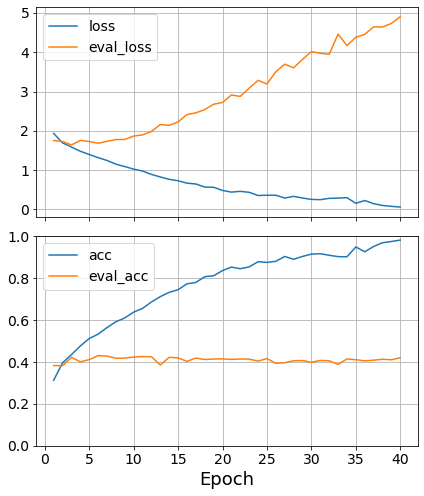

In [35]:
def plot_hist2(history):
  fig = plt.figure(figsize=(6, 7))
  ax1 = plt.subplot(211)
  plt.plot(history["epochs"], history["metrics"]["loss"], label="loss")
  plt.plot(history["epochs"], history["metrics"]["eval_loss"], label="eval_loss")
  plt.grid(True)
  plt.setp(ax1.get_xticklabels(), visible=False)
  plt.legend()
  plt.subplot(212)
  plt.plot(history["epochs"], history["metrics"]["acc"], label="acc")
  plt.plot(history["epochs"], history["metrics"]["eval_acc"], label="eval_acc")
  plt.grid(True)
  plt.xlabel("Epoch", fontsize=18)
  plt.ylim([0, 1])
  plt.legend()
  plt.tight_layout()
  plt.show()

plot_hist2(hist)

In [36]:
model.evaluate(test_dataloader)

As we can see now the results of the evaluation on the test set match our observations on the evaluation set.

## Overfitting

As we can see from the previous figure, our training loss can reduce to almost 0 (no errors) and the training accuracy converges to almost 100%. But, the accuracy for validation data gets stuck and, more interestingly, the validation loss starts decreasing but then starts increasing. This is the clear sign of **overfitting**. Our model starts learning but at some point it starts memorizing the training data losing generalization to unseen data. This effect is more dramatic on the test data. If we do nothing, neural networks tend to always overfit. Let's see some techniques to reduce this problem.

### Regularization

Regularization refers to all the techinques that we use to reduce the complexity of our model, hence reducing overfitting and improving generalization. One common regularization tool is $l_2$ regularization that constrain the connection weights. This can be implemented as an extra term on the loss function

\begin{equation}
    l = CE(\hat{y}, y) + \alpha \frac{1}{2} || \mathbf{w} ||_ 2
\end{equation}

where $CE$ is the Cross-entropy loss, $\mathbf{w}$ are the network's parameters and $\alpha$ is a constant that determines how much regularization we apply.

In `Pytorch` we have this option implemented in the optimizer, called `weight_decay`(this is true only for SGD optimizer).

In [37]:
net = torch.nn.Sequential(
    torch.nn.Linear(32*32*3, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 10)
)

model = Model(net)

model.compile(optimizer = torch.optim.SGD(model.net.parameters(), lr=0.1, weight_decay=0.01),
              loss = torch.nn.CrossEntropyLoss(),
              metrics=[Accuracy()])

hist = model.fit(train_dataloader, eval_dataloader, epochs=40)

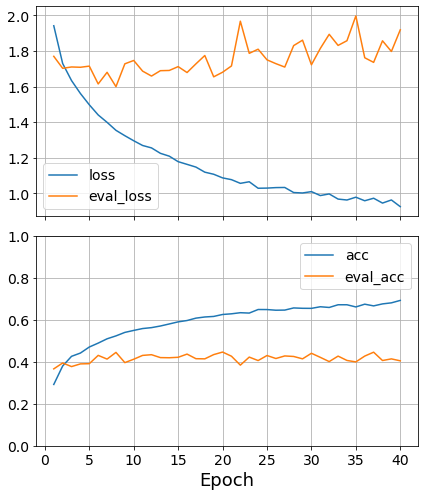

In [38]:
plot_hist2(hist)

In [39]:
model.evaluate(test_dataloader)

Our metrics on the training data are lower, but on the evaluation and test set are bigger (which means our model is more general with less overfiting). We can also see that the curve for the evaluation loss now is more stable.

### Early Stopping

Early stopping consists on tracking the performance of our model and stop training after some epochs without improvement, then retrieve the best model.

In [40]:
net = torch.nn.Sequential(
    torch.nn.Linear(32*32*3, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 10)
)

model = Model(net)

model.compile(optimizer = torch.optim.SGD(model.net.parameters(), lr=0.1),
              loss = torch.nn.CrossEntropyLoss(),
              metrics=[Accuracy()])

hist = model.fit(train_dataloader, eval_dataloader, epochs=40, early_stopping=5)

best model found at epoch 1 with eval_loss 1.76986
best model found at epoch 2 with eval_loss 1.72799
best model found at epoch 3 with eval_loss 1.67308
best model found at epoch 4 with eval_loss 1.67105
best model found at epoch 6 with eval_loss 1.66188
training stopped at epoch 11


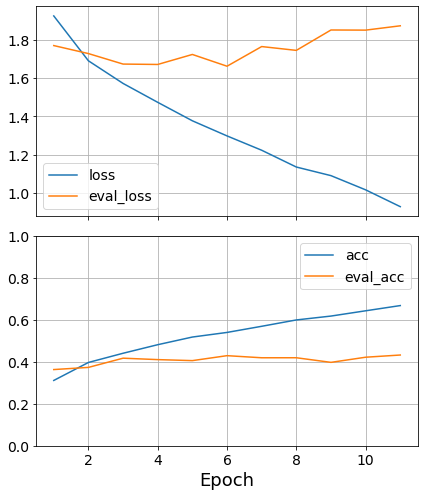

In [41]:
plot_hist2(hist)

In [42]:
model.evaluate(test_dataloader)

We don't need to train all the epochs if we already see that our evaluation metrics start to get worse.

### Dropout

Dropout is a popular technique to reduce overfitting. The idea is based on deactivating neurons randomly during training. This means that the neural network is forced to seek for alternative ways to represent the data.

![dropout](https://miro.medium.com/proxy/1*iWQzxhVlvadk6VAJjsgXgg.png)

We can use our representative subset to quickly find the best combination of dropout probabilities and the rest of hyperparameters.

In [43]:
net = torch.nn.Sequential(
    torch.nn.Linear(32*32*3, 100),
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.5),
    torch.nn.Linear(100, 100),
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.3),
    torch.nn.Linear(100, 10)
)

model = Model(net)

model.compile(optimizer = torch.optim.SGD(model.net.parameters(), lr=0.1),
              loss = torch.nn.CrossEntropyLoss(),
              metrics=[Accuracy()])

hist = model.fit(train_dataloader, eval_dataloader, epochs=40)

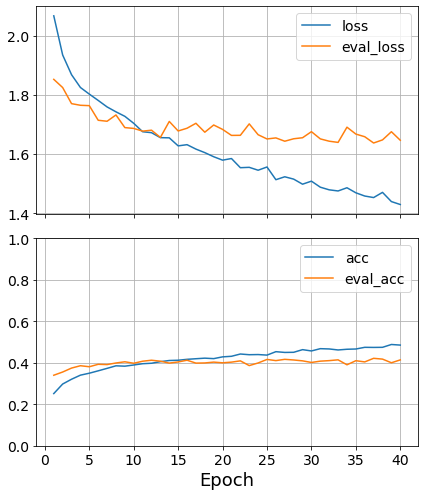

In [44]:
plot_hist2(hist)

In [45]:
model.evaluate(test_dataloader)

Now our training curves match better the evaluation ones, indicating that our model is not overffiting. This doesn't mean, however, that our model performs better.

### Use more data

The most effective way (but not always possible) to reduce overfitting is using more data.

In [46]:
train_dataset = Dataset(train_images, (mean, std), train_labels)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)

len(train_dataset)

40000

In [47]:
net = torch.nn.Sequential(
    torch.nn.Linear(32*32*3, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 10)
)

model = Model(net)

model.compile(optimizer = torch.optim.SGD(model.net.parameters(), lr=0.1),
              loss = torch.nn.CrossEntropyLoss(),
              metrics=[Accuracy()])

hist = model.fit(train_dataloader, eval_dataloader, epochs=40)

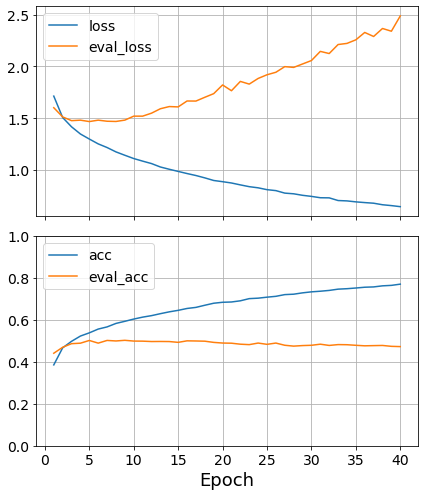

In [48]:
plot_hist2(hist)

In [49]:
model.evaluate(test_dataloader)

Even using all the dataset we still see overfitting. We need even more data.

### Data Augmentation

One very effective way for reducing overffiting is data augmentation. It consists on applying random transformations on the data so the network never sees the same sample. Both Keras/Tensorflow and Pytorch (Torchvision or the corresponding data library) include their own transformations. There are also third party libraries that can offer more performance and flexibility, such as [albumentations](https://github.com/albumentations-team/albumentations). It can be seen as an artificial way to get more data.

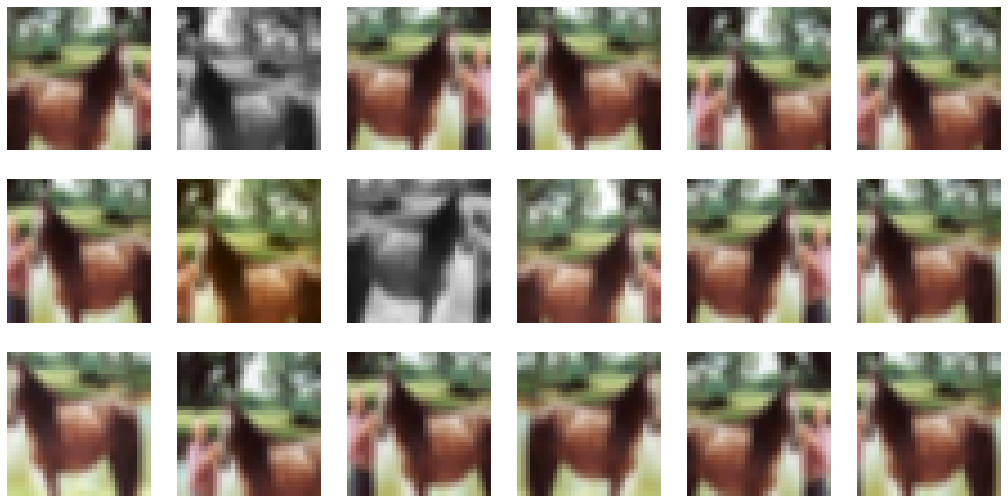

In [51]:
from albumentations import Compose, RandomCrop, Resize, HorizontalFlip, ToGray, RGBShift, OneOf

trans = Compose([
    RandomCrop(24,24),
    Resize(32, 32),
    HorizontalFlip(),
    OneOf([
        ToGray(p=0.2),
        RGBShift(p=0.3)
    ])
])

idx = 1
r, c = 3, 6
plt.figure(figsize=(c*3, r*3))
for row in range(r):
    for col in range(c):
        ix = c*row + col
        plt.subplot(r, c, ix + 1)
        img = train_images[idx]
        # apply transformation
        img = trans(image=img)["image"]
        plt.imshow(img)
        plt.axis('off')
plt.subplots_adjust(wspace=0.1, hspace=0.2)
plt.show()

In [52]:
class Dataset(torch.utils.data.Dataset):
  def __init__(self, X, stats, y=None, train=True, trans=None):
    self.X = X
    self.mean, self.std = stats
    self.y = y
    self.train = train
    self.trans = trans

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    img = self.X[ix]
    if self.trans:
        img = self.trans(image=img)["image"]
    img = torch.from_numpy(img / 255.)
    img = (img - self.mean) / self.std
    img = img.view(-1).float()
    if self.train:
        label = torch.tensor(self.y[ix]).long()
        return img, label
    return img

In [78]:
train_dataset = Dataset(subset_images, (mean, std), subset_labels, trans=trans)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)

len(train_dataset)

8000

In [54]:
net = torch.nn.Sequential(
    torch.nn.Linear(32*32*3, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 10)
)

model = Model(net)

model.compile(optimizer = torch.optim.SGD(model.net.parameters(), lr=0.1),
              loss = torch.nn.CrossEntropyLoss(),
              metrics=[Accuracy()])

hist = model.fit(train_dataloader, eval_dataloader, epochs=40)

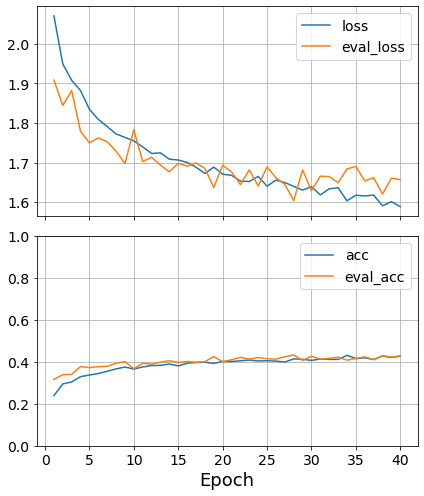

In [55]:
plot_hist2(hist)

In [56]:
model.evaluate(test_dataloader)

The model now has much more difficulties to overfit since it rearely sees the same image twice! Also, any improvement on the training data is reflected similarly on the evaluation (and test) data. 

You could also apply data augmentation in the evaluation or testing part, just feed the network with several augmented versions of the same image and keep the most voted class. This is called **test time augmentation**, or *TTA*.

## Faster training

Training a deep neural network with a lot of data can be very slow. Let's see some techniques to accelerate the training.

### Faster optimizers

![optim](http://raw.githubusercontent.com/wassname/viz_torch_optim/master/docs/videos/beales_20171117_00-02-20_2d.gif)

Remember from previous lessons the Gradient Descent algorithm, where we compute the derivative of the less function w.r.t. the network parameters and then perform the update $w \leftarrow w - \eta \frac{\partial l}{\partial w}$. This is the original and simplest formulation of Stochastic Gradient Descent, and it is the optimizer we have been using up until know. However, some improvements can be done upon this simple update rule to accelerate the optimization process.

#### Momentum optimization

Momentum optimization takes into account previous gradients to "accelerate" the learning process very much like ball rolling down a slope will start out slowly but accelerating by picking up momentum.

\begin{equation}
\begin{array}{l}
    m \leftarrow \beta m - \eta \frac{\partial l}{\partial w} \\
    w \leftarrow w + m
    \end{array}
\end{equation}

In [79]:
net = torch.nn.Sequential(
    torch.nn.Linear(32*32*3, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 10)
)

model = Model(net)

model.compile(optimizer = torch.optim.SGD(model.net.parameters(), lr=0.01, momentum=0.9),
              loss = torch.nn.CrossEntropyLoss(),
              metrics=[Accuracy()])

hist = model.fit(train_dataloader, eval_dataloader, epochs=40)

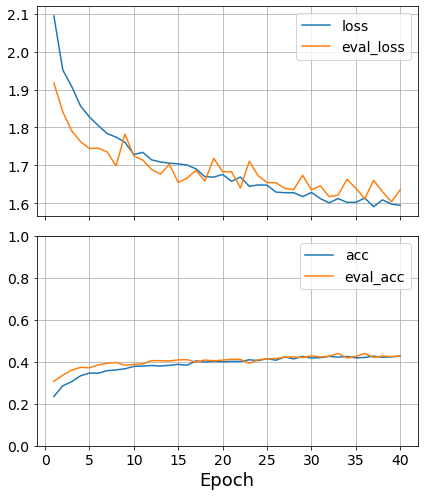

In [80]:
plot_hist2(hist)

In [81]:
model.evaluate(test_dataloader)

To be able to converge nicely we may require a lower learning rate (in order to avoid overshooting).

#### RMSprop

Gradient Descent works by quickly going down the steepest slope, which may not point straight toward the global optimum. We can account for this by scaling down the gradient vector along the steepest dimensions. 

\begin{equation}
\begin{array}{l}
    s \leftarrow \beta s + (1 - \beta) \frac{\partial l}{\partial w} \otimes \frac{\partial l}{\partial w} \\
    w \leftarrow w - \eta \frac{\partial l}{\partial w} ⊘ \sqrt{s+\epsilon}
\end{array}
\end{equation}

where $\beta$ is the decay rate (normally 0.9) and $\epsilon$ is a smoothing term to avoid division by zero.

In [82]:
net = torch.nn.Sequential(
    torch.nn.Linear(32*32*3, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 10)
)

model = Model(net)

model.compile(optimizer = torch.optim.RMSprop(model.net.parameters(), lr=0.001),
              loss = torch.nn.CrossEntropyLoss(),
              metrics=[Accuracy()])

hist = model.fit(train_dataloader, eval_dataloader, epochs=40)

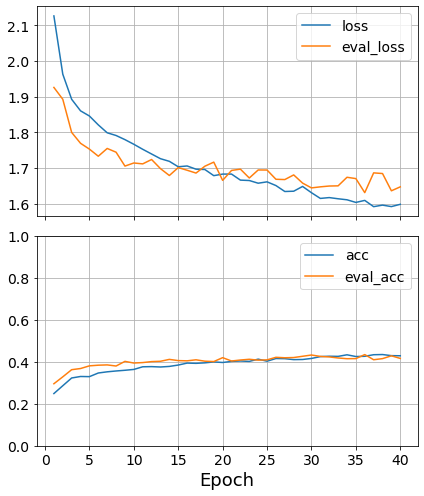

In [83]:
plot_hist2(hist)

In [84]:
model.evaluate(test_dataloader)

#### Adam

*Adam* combines ideas from momentum optimization and RMSprop, keeping track of an exponentially decaying average of past gradients and also an exponentially decaying average of past squared gradients.

\begin{equation}
    \begin{array}{l}
        m \leftarrow \beta_1 m - (º-\beta_1) \frac{\partial l}{\partial w} \\
        s \leftarrow \beta_2 s + (1 - \beta_2) \frac{\partial l}{\partial w} \otimes \frac{\partial l}{\partial w} \\
        \hat{m} \leftarrow \frac{m}{1 - \beta_1^T} \\
        \hat{s} \leftarrow \frac{s}{1-\beta_2^T} \\
        w \leftarrow w + \eta \, \hat{m} ⊘ \sqrt{\hat{s}+\epsilon}
    \end{array}
\end{equation}

In [85]:
net = torch.nn.Sequential(
    torch.nn.Linear(32*32*3, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 10)
)

model = Model(net)

model.compile(optimizer = torch.optim.Adam(model.net.parameters(), lr=0.001),
              loss = torch.nn.CrossEntropyLoss(),
              metrics=[Accuracy()])

hist = model.fit(train_dataloader, eval_dataloader, epochs=40)

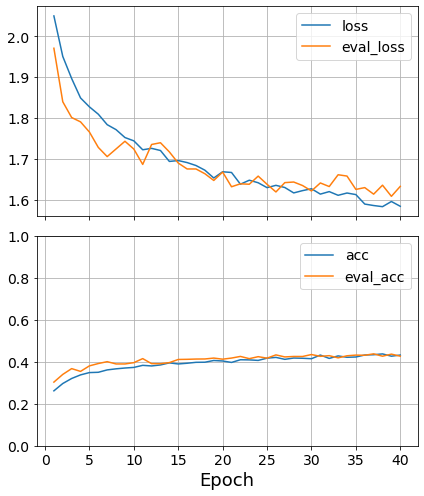

In [86]:
plot_hist2(hist)

In [87]:
model.evaluate(test_dataloader)

### Learning Rate Scheduling

 We can also accelerate learning by changing the learning rate during training. You have a lot of different [options](https://pytorch.org/docs/stable/optim.html) to choose from, or even create your own.

 ![lr](http://cs231n.github.io/assets/nn3/learningrates.jpeg)

In [88]:
net = torch.nn.Sequential(
    torch.nn.Linear(32*32*3, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 10)
)

model = Model(net)

optimizer = torch.optim.SGD(model.net.parameters(), lr=0.1)

# divide learning rate by 2 every 10 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 10, 0.5)

model.compile(optimizer = optimizer,
              loss = torch.nn.CrossEntropyLoss(),
              scheduler = scheduler,
              metrics=[Accuracy()])

hist = model.fit(train_dataloader, eval_dataloader, epochs=30)

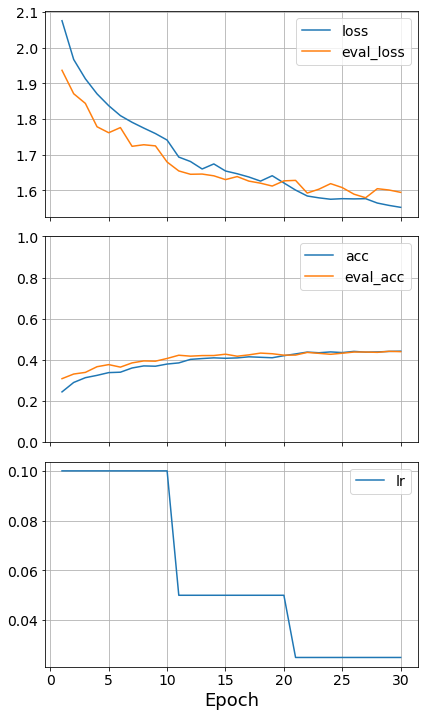

In [89]:
def plot_hist3(history):
  fig = plt.figure(figsize=(6, 10))
  ax1 = plt.subplot(311)
  plt.plot(history["epochs"], history["metrics"]["loss"], label="loss")
  plt.plot(history["epochs"], history["metrics"]["eval_loss"], label="eval_loss")
  plt.grid(True)
  plt.setp(ax1.get_xticklabels(), visible=False)
  plt.legend()
  ax2 = plt.subplot(312, sharex=ax1)
  plt.plot(history["epochs"], history["metrics"]["acc"], label="acc")
  plt.plot(history["epochs"], history["metrics"]["eval_acc"], label="eval_acc")
  plt.grid(True)
  plt.ylim([0, 1])
  plt.setp(ax2.get_xticklabels(), visible=False)
  plt.legend()
  plt.subplot(313, sharex=ax1)
  plt.plot(history["epochs"], history["lr"], label="lr")
  plt.grid(True)
  plt.xlabel("Epoch", fontsize=18)
  plt.legend()
  plt.tight_layout()
  plt.show()

plot_hist3(hist)

In [90]:
model.evaluate(test_dataloader)

You can see the bumps in the metrics when the learning rate is changed.

In [91]:
net = torch.nn.Sequential(
    torch.nn.Linear(32*32*3, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 10)
)

model = Model(net)

optimizer = torch.optim.SGD(model.net.parameters(), lr=0.1)

# start from small value, grow linealy from some epochs, then decrease. Repeat cycle.
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.01, max_lr=0.1, step_size_up=5, step_size_down=15)

model.compile(optimizer = optimizer,
              loss = torch.nn.CrossEntropyLoss(),
              scheduler = scheduler,
              metrics=[Accuracy()])

hist = model.fit(train_dataloader, eval_dataloader, epochs=40)

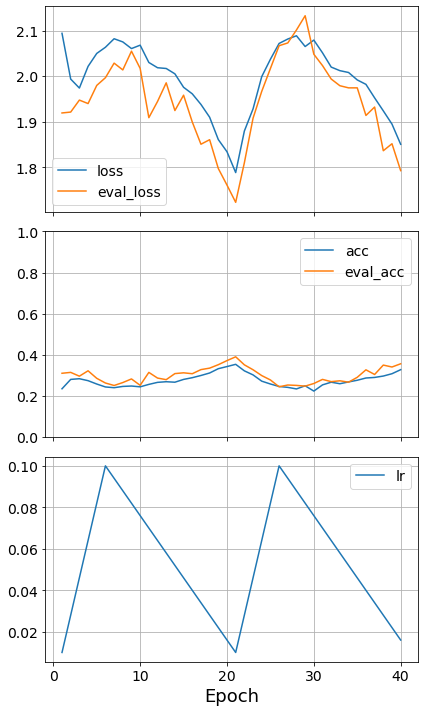

In [92]:
plot_hist3(hist)

In [93]:
model.evaluate(test_dataloader)

A cyclic learning rate can explore multiple local optima in one run, being able to converge and escape. If we keep the best model during training we may find a better solution than other learning rate schedulers.

### Batch Normalization

This is a normalization technique that can accelerate training and also act as a regularization method, reducing overfitting. It consists on a layer that zero-centers and normalizes each input and then scales and shifts the result using two parameters. Since this parameters are learnable, the network can decide the best way to scale and shift the layer's inputs to achieve its task.

In [94]:
net = torch.nn.Sequential(
    torch.nn.Linear(32*32*3, 100),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(100),
    torch.nn.Linear(100, 100),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(100),
    torch.nn.Linear(100, 10)
)

model = Model(net)

optimizer = torch.optim.SGD(model.net.parameters(), lr=0.1)

model.compile(optimizer = optimizer,
              loss = torch.nn.CrossEntropyLoss(),
              metrics=[Accuracy()])

hist = model.fit(train_dataloader, eval_dataloader, epochs=40)

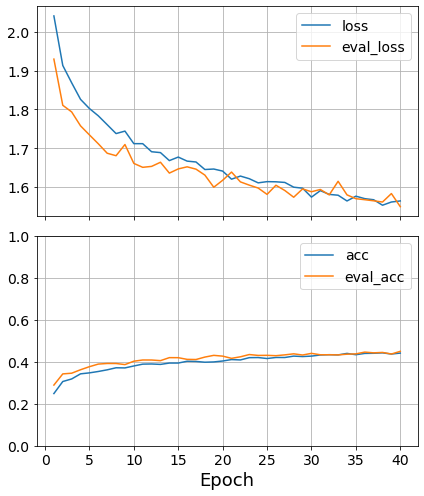

In [95]:
plot_hist2(hist)

In [96]:
model.evaluate(test_dataloader)

### Transfer learning

Transfer learning is a technique consisting in training a neural network in one dataset and then applying it in a different one. If the features learned on the first dataset are transferable to the second task, then we can avoid re-training the entire network from scratch again. For computer vision applications, in practice we train networks on very big datasets like Imagenet and save them to future re-use in different datasets of similar images (in this case, natural images).

This process can be further extended by re-training the entire network on the new dataset, but now starting from a better initialization often requiring lot less data and computation to converge to a good solution. Transfer learning is a very powerful technique, and we will apply it extensively from now on.

## Putting everything together

Let's train with all our data, and now using some of the tricks that we have learnt. Some of the best choices are:

- Weight decay (with SGD)
- Batch Norm / Dropout
- Data augmentation
- Learning Rate scheduling / Early stopping
- SGD with momentum / Adam / RMSprop 
- Transfer learning (we will see this in the coming lessons)

In [97]:
train_dataset = Dataset(train_images, (mean, std), train_labels, trans=trans)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)

len(train_dataset)

40000

In [101]:
net = torch.nn.Sequential(
    torch.nn.Linear(32*32*3, 100),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(100),
    torch.nn.Linear(100, 100),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(100),
    torch.nn.Linear(100, 10)
)

optimizer = torch.optim.Adam(model.net.parameters())
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 10, 0.5)

model.compile(optimizer = optimizer,
              loss = torch.nn.CrossEntropyLoss(),
              scheduler = scheduler,
              metrics=[Accuracy()])

hist = model.fit(train_dataloader, eval_dataloader, epochs=30)

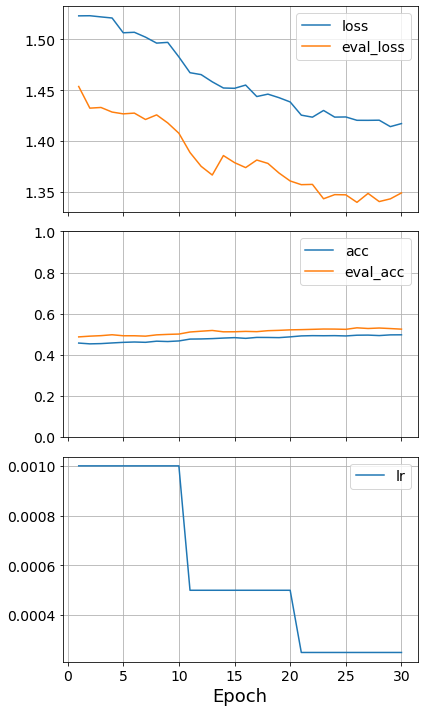

In [102]:
plot_hist3(hist)

In [103]:
model.evaluate(test_dataloader)

We can see that our evaluation loss/accuracy is always better than for the training data, and also that our test metrics are better and more consistent with the values seen during training. This is a sign that we are doing things right !